앞서 언급했듯이, Test set과 Train Set은 직접 크롤링하여 데이터를 얻기 어려워 만들어진 자료를 기반으로 딥러닝을 구현할 예정이다. 이 데이터는 네이버 영화 리뷰 데이터를 모아 긍정적 리뷰이면 1, 부정적 리뷰면 0으로 판별한 데이터 셋이다. 

# 자연어 처리를 통해 딥러닝 환경 구현

Step 1 필요한 모듈로 부터 필요한 함수 임포트하기

In [1]:
import pandas as pd
import numpy as np
import numpy
import json
import os
from konlpy.tag import Okt #강의 시간에 배운 konlpy를 이용해 불용어를 처리한다.


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

STEP2 데이터를 정리하기 

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

딥러닝에 방해되는 데이터(공백, Null)등을 제거하는 작업 

In [3]:
train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'].replace('', np.nan, inplace=True) #빈 값을 NULL로 변경 
train_data = train_data.dropna(how = 'any') #Null 값 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외한 모든 기호(특수 문자, 영어)를 제거하는 작업

In [4]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

STEP 3 토큰화

In [5]:
okt = Okt() 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [6]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

STEP 4 정수 인코딩

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

귀납적으로 분석하는 것이기에, 적은 빈도수가 나오는 단어들은 제거하는 작업을 거쳐 정확도를 높일 예정이다.

In [8]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
vocab_size = total_cnt - rare_cnt + 2


In [9]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

빈도 수가 적은 단어들을 제거했으므로 그 부분은 공백이 됬음을 의미함. 이 공백을 다시 제거해 딥러닝을 진행할 예정

In [11]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
#길이가 0인 것들의 인덱스를 받아온다.

max_len=30
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

In [12]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
        
below_threshold_len(max_len, X_train)

In [13]:
X_train = pad_sequences(X_train, maxlen = 30)
X_test = pad_sequences(X_test, maxlen = 30)

# STEP 5  모델 불러오기

In [14]:
model = load_model('model1.h5')
model.summary() # 모델 간단히 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

STEP 6 모델 실행하기

In [16]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2298 - acc: 0.9078
Epoch 00001: val_acc improved from -inf to 0.85510, saving model to best_model_1.h5
1939/1939 [==============================] - 119s 62ms/step - loss: 0.2298 - acc: 0.9078 - val_loss: 0.3458 - val_acc: 0.8551
Epoch 2/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9152
Epoch 00002: val_acc did not improve from 0.85510
1939/1939 [==============================] - 102s 53ms/step - loss: 0.2137 - acc: 0.9152 - val_loss: 0.3667 - val_acc: 0.8522
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.1984 - acc: 0.9222
Epoch 00003: val_acc did not improve from 0.85510
1939/1939 [==============================] - 105s 54ms/step - loss: 0.1984 - acc: 0.9222 - val_loss: 0.3644 - val_acc: 0.8486
Epoch 4/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.1817 - acc: 0.9295
Epoch 00004: val_acc did not improve from 0.85510
1939/1939 [=====

In [17]:
loaded_model = load_model('best_model_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
a,b = model.evaluate(x=X_test, y=y_test, verbose=0) # 63개의 테스트 데이터셋 결과 

1537/1537 [==============================] - 15s 10ms/step - loss: 0.3535 - acc: 0.8501

 테스트 정확도: 0.8501


In [18]:
# 테스트 데이터셋의 loss
vloss1=history.history['val_loss']

# 학습 데이터셋의 accuracy 
acc1=history.history['acc']

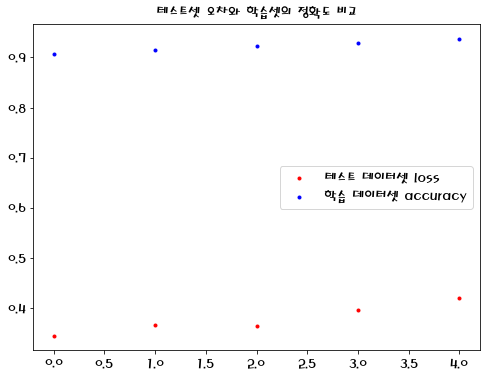

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager   # 한글 사용을 위해서 임포트 

x_len = numpy.arange(len(acc1))
plt.figure(figsize=(8,6))   #그래프의 크기 셋팅
font_path = "C:\\Windows\\Fonts\\HMKMMAG.TTF"
font_name = matplotlib.font_manager.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name, size=14) 

# 학습 데이터셋의 accuracy는 파란색으로, 테스트 데이터셋의 loss는 빨간색으로 표시
plt.title('테스트셋 오차와 학습셋의 정확도 비교', fontsize=14)
plt.plot(x_len, vloss1, "o", c="red",  markersize=3,  label='테스트 데이터셋 loss')
plt.plot(x_len, acc1,   "o", c="blue", markersize=3,  label='학습 데이터셋 accuracy')
plt.legend() # 범례 출력

plt.show()

STEP 7 실제 리뷰에 모델 적용하기 (리뷰 예측해보기)

In [20]:
def review_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    t = float(model.predict(pad_new)) # 예측
    if (t>0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다 \n".format(t*100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다 \n".format((1-t)*100))
        
def review(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    t = float(model.predict(pad_new)) # 예측
    if (t>0.5):
        print("긍정 리뷰입니다 \n")
    else:
        print("부정 리뷰입니다 \n")




In [21]:
review_predict("영화 진짜 재밌네 ㅋㅋ")

97.09% 확률로 긍정 리뷰입니다 



In [22]:
review_predict("진짜 개노잼")

99.90% 확률로 부정 리뷰입니다 



# 검증 데이터셋 적용해보기 

In [23]:
import csv

num1=0
num2=0 #영화의 긍정도를 판별하기 위한 변수

#경로 설정을 재설정하셔야 코드가 돌아갑니다!
with open('C:/ai/기말과제/a1.csv', newline='',encoding= 'UTF8') as csvfile:
       data = list(csv.reader(csvfile))

        
for i in data :
    if review(i[0])=="긍정 리뷰입니다":
        num1+=1
    else:
        num2+=1

if num1>num2:
    print("이 영화는 긍정적 평이 더 많습니다.")
elif num1==num2:
    print("이 영화는 긍정적인 평과 부정적인 평이 비슷합니다.")
else:
    print("이 영화는 부정적 평이 더 많습니다.")


부정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

부정 리뷰입니다 

긍정 리뷰입니다 

부정 리뷰입니다 

부정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

긍정 리뷰입니다 

부정 리뷰입니다 

긍정 리뷰입니다 

부정 리뷰입니다 

긍정 리뷰입니다 

부정 리뷰입니다 

부정 리뷰입니다 

긍정 리뷰입니다 

이 영화는 부정적 평이 더 많습니다.


# 실제로 영화 반도가 재미 없다는 평이 많은데, 영화 반도를 넣어봤을 때 딥러닝을 통해 부정적 평가가 더 많다는 것을 알 수 있었다.